In [1]:
import warnings
warnings.filterwarnings('ignore')
#%matplotlib inline
import numpy as np
import pandas as pd

In [2]:
##################  Загрузка данных
#Data1 = pd.read_csv('D:\Coding\data\phone_user_review_file_1.csv', encoding= 'ANSI')
#Data2 = pd.read_csv('D:\Coding\data\phone_user_review_file_2.csv', encoding= 'ANSI')
#Data3 = pd.read_csv('D:\Coding\data\phone_user_review_file_3.csv', encoding= 'ANSI')
#Data4 = pd.read_csv('D:\Coding\data\phone_user_review_file_4.csv', encoding= 'ANSI')
#Data5 = pd.read_csv('D:\Coding\data\phone_user_review_file_5.csv', encoding= 'ANSI')
Data6 = pd.read_csv('D:\Coding\data\phone_user_review_file_6.csv', encoding= 'ANSI')

#total_data = pd.concat([Data1,Data2, Data3, Data4, Data5, Data6], axis=0)
total_data = Data6

total_data.shape

(163837, 11)

In [3]:
total_data[['lang', 'score', 'extract']].head()

,lang,score,extract
0,en,8.0,I've had the phone for awhile and it's a prett...
1,en,6.0,to be clear it is not the sellers fault that t...
2,en,9.0,Well i love this phone. i have had ton of phon...
3,en,4.0,I have had my Instinct for several months now ...
4,en,6.0,i have had this instinct phone for about two m...


In [4]:
##################  Препроцессинг

In [5]:
import nltk
nltk.download('stopwords')
from sklearn.metrics import mean_squared_error
import re #regular expressions
from nltk.corpus import stopwords #stopwords

import pymorphy2 #Для лемматизации
morph = pymorphy2.MorphAnalyzer()

#Добавление списка stopwords
stops = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Алексей\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def review_to_wordlist(review):
    #1) - регулярное выражение к тексту
    review_text = re.sub("[^а-яА-Яa-zA-Z]"," ", review)
    #2) - разделение текста на список слов
    words = review_text.lower().split()
    #3) - удаление stopwords из списка слов
    words = [w for w in words if not w in stops]
    #4) - лемматизация слов
    words = [morph.parse(w)[0].normal_form for w in words ]
    return(words)

In [7]:
data = total_data[(total_data.lang == 'en')]
data = data[['score', 'extract']]
data = data.dropna()

In [8]:
print("data.shape(): ", data.shape)

data.shape():  (49093, 2)


In [9]:
data['content_clear'] = data['extract'].apply(review_to_wordlist)

In [10]:
print("1-й комментрий: \ndata['content_clear'][0]: ", data['content_clear'][0])

1-й комментрий: 
data['content_clear'][0]:  ['phone', 'awhile', 'pretty', 'good', 'phone', 'call', 'quality', 'response', 'sms', 'mms', 'much', 'faster', 'data', 'g', 'runs', 'like', 'g', 'network', 'phone', 'pretty', 'much', 'like', 'android', 'except', 'without', 'widgets', 'market']


In [56]:
#data['score_2'] = data['score'].astype('int')
data['score_2'] = data['score']

In [57]:
# mapping y

def er_funtion(y):
    l = list(y)
    for i in range(0, len(y)):
        if (y[i] <=3):
            l[i] = 1
        elif (y[i] >=7):
            l[i] = 3
        else:
            l[i] = 2

    return (l)


In [58]:
data['mapped_y'] = data['score_2'].apply(er_funtion)
#data['mapped_y'] = er_funtion(data['score_2'])

TypeError: 'float' object is not iterable

In [27]:
l = list(data['score_2'])
for i in range(0, len(data['score_2'])):
    if (data['score_2'][i] <=3):
        l[i] = 1
    elif (data['score_2'][i] >=7):
        l[i] = 3
    else:
        l[i] = 2

KeyError: 5

In [30]:
data['score_2'][1]<=3

True

############## Word2vec ##############

In [11]:
import gensim
from gensim.models import word2vec
from multiprocessing import cpu_count

######## Скачивание готовой натренированной модели 
model_w2v = gensim.models.KeyedVectors.load_word2vec_format('D:\Coding\Word2vec\GoogleNews-vectors-negative300.bin\GoogleNews-vectors-negative300.bin', binary=True)
w2v = dict(zip(model_w2v.wv.index2word, model_w2v.wv.syn0))

print("Done!")

Done!


In [15]:
# Посмотрим чему выучилась модель:
#model_w2v.wv.most_similar(positive=['phone'])

[('telephone', 0.8224020600318909),
 ('cell_phone', 0.7831966876983643),
 ('cellphone', 0.7629485130310059),
 ('Phone', 0.7060797810554504),
 ('phones', 0.6894922256469727),
 ('landline', 0.6263927221298218),
 ('voicemail', 0.6252243518829346),
 ('caller_id', 0.6023745536804199),
 ('RingCentral_cloud_computing', 0.5935890674591064),
 ('telephones', 0.5929964780807495)]

############## mean_vectorizer ##############

In [12]:
class mean_vectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(w2v.values())))

    def fit(self, X):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [13]:
data_mean = mean_vectorizer(w2v).fit(data['content_clear']).transform(data['content_clear'])
data_mean.shape

(49093, 300)

In [14]:
from sklearn.model_selection import train_test_split

y = data['score']
Xtr, Xval, ytr, yval = train_test_split(data_mean, y, test_size=0.33, random_state=42)

In [15]:
print("Xtr.shape(): ", Xtr.shape,
      "\nXval.shape(): ", Xval.shape,
      "\nytr.mean(): ", ytr.mean(),
      "\nyval.mean(): ", yval.mean()
      )

Xtr.shape():  (32892, 300) 
Xval.shape():  (16201, 300) 
ytr.mean():  7.243080384287974 
yval.mean():  7.228380964138016


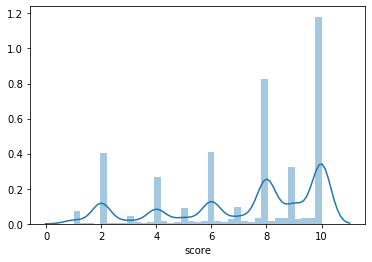

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.distplot(ytr)

plt.show()

############# подготовка #############

In [17]:
ytr[:10]

66734      9.0
62376     10.0
78493      2.7
89276      1.0
73820     10.0
48015     10.0
41700      9.0
134363    10.0
109962     8.0
96023      9.2
Name: score, dtype: float64

In [18]:
from sklearn import utils
ytr1 = ytr.astype('int')
yval1 = yval.astype('int')
utils.multiclass.type_of_target(ytr1)

'multiclass'

In [19]:
ytr1[:10]

66734      9
62376     10
78493      2
89276      1
73820     10
48015     10
41700      9
134363    10
109962     8
96023      9
Name: score, dtype: int32

############# CatBoostRegressor #############

In [20]:
from catboost import CatBoostRegressor

regr = CatBoostRegressor()

In [21]:
regr.fit(Xtr, ytr1)

Learning rate set to 0.072685
0:	learn: 2.7178702	total: 165ms	remaining: 2m 44s
1:	learn: 2.6967147	total: 227ms	remaining: 1m 53s
2:	learn: 2.6763535	total: 298ms	remaining: 1m 39s
3:	learn: 2.6591767	total: 356ms	remaining: 1m 28s
4:	learn: 2.6436460	total: 418ms	remaining: 1m 23s
5:	learn: 2.6274974	total: 477ms	remaining: 1m 19s
6:	learn: 2.6130342	total: 538ms	remaining: 1m 16s
7:	learn: 2.6008861	total: 608ms	remaining: 1m 15s
8:	learn: 2.5896289	total: 668ms	remaining: 1m 13s
9:	learn: 2.5791901	total: 728ms	remaining: 1m 12s
10:	learn: 2.5676830	total: 783ms	remaining: 1m 10s
11:	learn: 2.5577011	total: 859ms	remaining: 1m 10s
12:	learn: 2.5487504	total: 920ms	remaining: 1m 9s
13:	learn: 2.5398791	total: 978ms	remaining: 1m 8s
14:	learn: 2.5319254	total: 1.03s	remaining: 1m 7s
15:	learn: 2.5246580	total: 1.1s	remaining: 1m 7s
16:	learn: 2.5173866	total: 1.15s	remaining: 1m 6s
17:	learn: 2.5103606	total: 1.21s	remaining: 1m 5s
18:	learn: 2.5039617	total: 1.26s	remaining: 1m 5s


160:	learn: 2.2287246	total: 8.76s	remaining: 45.7s
161:	learn: 2.2275542	total: 8.81s	remaining: 45.6s
162:	learn: 2.2264757	total: 8.86s	remaining: 45.5s
163:	learn: 2.2253521	total: 8.9s	remaining: 45.4s
164:	learn: 2.2241709	total: 8.95s	remaining: 45.3s
165:	learn: 2.2231368	total: 8.99s	remaining: 45.2s
166:	learn: 2.2218485	total: 9.04s	remaining: 45.1s
167:	learn: 2.2205258	total: 9.08s	remaining: 45s
168:	learn: 2.2196003	total: 9.12s	remaining: 44.9s
169:	learn: 2.2182697	total: 9.17s	remaining: 44.8s
170:	learn: 2.2170885	total: 9.22s	remaining: 44.7s
171:	learn: 2.2158548	total: 9.26s	remaining: 44.6s
172:	learn: 2.2146494	total: 9.31s	remaining: 44.5s
173:	learn: 2.2134715	total: 9.36s	remaining: 44.5s
174:	learn: 2.2121744	total: 9.41s	remaining: 44.4s
175:	learn: 2.2112380	total: 9.46s	remaining: 44.3s
176:	learn: 2.2100280	total: 9.51s	remaining: 44.2s
177:	learn: 2.2091409	total: 9.56s	remaining: 44.1s
178:	learn: 2.2078965	total: 9.61s	remaining: 44.1s
179:	learn: 2.2

320:	learn: 2.0669516	total: 17s	remaining: 36s
321:	learn: 2.0660690	total: 17.1s	remaining: 35.9s
322:	learn: 2.0653538	total: 17.1s	remaining: 35.9s
323:	learn: 2.0644492	total: 17.2s	remaining: 35.8s
324:	learn: 2.0636596	total: 17.2s	remaining: 35.7s
325:	learn: 2.0628969	total: 17.3s	remaining: 35.7s
326:	learn: 2.0621300	total: 17.3s	remaining: 35.6s
327:	learn: 2.0612469	total: 17.4s	remaining: 35.6s
328:	learn: 2.0607186	total: 17.4s	remaining: 35.5s
329:	learn: 2.0597336	total: 17.5s	remaining: 35.5s
330:	learn: 2.0590152	total: 17.5s	remaining: 35.4s
331:	learn: 2.0581548	total: 17.6s	remaining: 35.3s
332:	learn: 2.0572429	total: 17.6s	remaining: 35.3s
333:	learn: 2.0564382	total: 17.7s	remaining: 35.2s
334:	learn: 2.0555041	total: 17.7s	remaining: 35.2s
335:	learn: 2.0546198	total: 17.8s	remaining: 35.1s
336:	learn: 2.0536998	total: 17.8s	remaining: 35.1s
337:	learn: 2.0528560	total: 17.9s	remaining: 35s
338:	learn: 2.0522204	total: 17.9s	remaining: 35s
339:	learn: 2.051287

480:	learn: 1.9410668	total: 25.2s	remaining: 27.2s
481:	learn: 1.9403960	total: 25.2s	remaining: 27.1s
482:	learn: 1.9398826	total: 25.3s	remaining: 27.1s
483:	learn: 1.9390422	total: 25.3s	remaining: 27s
484:	learn: 1.9383423	total: 25.4s	remaining: 27s
485:	learn: 1.9377052	total: 25.4s	remaining: 26.9s
486:	learn: 1.9369970	total: 25.5s	remaining: 26.8s
487:	learn: 1.9362801	total: 25.5s	remaining: 26.8s
488:	learn: 1.9357315	total: 25.6s	remaining: 26.7s
489:	learn: 1.9350613	total: 25.6s	remaining: 26.7s
490:	learn: 1.9342928	total: 25.7s	remaining: 26.6s
491:	learn: 1.9337680	total: 25.8s	remaining: 26.6s
492:	learn: 1.9331499	total: 25.8s	remaining: 26.6s
493:	learn: 1.9322930	total: 25.9s	remaining: 26.5s
494:	learn: 1.9316163	total: 25.9s	remaining: 26.5s
495:	learn: 1.9309276	total: 26s	remaining: 26.4s
496:	learn: 1.9300759	total: 26s	remaining: 26.4s
497:	learn: 1.9292798	total: 26.1s	remaining: 26.3s
498:	learn: 1.9285545	total: 26.2s	remaining: 26.3s
499:	learn: 1.927779

640:	learn: 1.8342347	total: 33.4s	remaining: 18.7s
641:	learn: 1.8336838	total: 33.5s	remaining: 18.7s
642:	learn: 1.8330986	total: 33.5s	remaining: 18.6s
643:	learn: 1.8325046	total: 33.6s	remaining: 18.6s
644:	learn: 1.8319198	total: 33.6s	remaining: 18.5s
645:	learn: 1.8312160	total: 33.7s	remaining: 18.4s
646:	learn: 1.8305311	total: 33.7s	remaining: 18.4s
647:	learn: 1.8297642	total: 33.8s	remaining: 18.3s
648:	learn: 1.8290368	total: 33.8s	remaining: 18.3s
649:	learn: 1.8284642	total: 33.9s	remaining: 18.2s
650:	learn: 1.8278885	total: 33.9s	remaining: 18.2s
651:	learn: 1.8273490	total: 34s	remaining: 18.1s
652:	learn: 1.8266646	total: 34s	remaining: 18.1s
653:	learn: 1.8260396	total: 34s	remaining: 18s
654:	learn: 1.8253789	total: 34.1s	remaining: 18s
655:	learn: 1.8249591	total: 34.1s	remaining: 17.9s
656:	learn: 1.8243529	total: 34.2s	remaining: 17.8s
657:	learn: 1.8238325	total: 34.2s	remaining: 17.8s
658:	learn: 1.8231532	total: 34.3s	remaining: 17.7s
659:	learn: 1.8225566	

803:	learn: 1.7356036	total: 41.5s	remaining: 10.1s
804:	learn: 1.7350461	total: 41.6s	remaining: 10.1s
805:	learn: 1.7344178	total: 41.6s	remaining: 10s
806:	learn: 1.7337078	total: 41.7s	remaining: 9.97s
807:	learn: 1.7332219	total: 41.7s	remaining: 9.92s
808:	learn: 1.7326455	total: 41.8s	remaining: 9.86s
809:	learn: 1.7322372	total: 41.8s	remaining: 9.81s
810:	learn: 1.7316443	total: 41.9s	remaining: 9.76s
811:	learn: 1.7310798	total: 41.9s	remaining: 9.71s
812:	learn: 1.7304425	total: 42s	remaining: 9.65s
813:	learn: 1.7300484	total: 42s	remaining: 9.6s
814:	learn: 1.7294601	total: 42.1s	remaining: 9.55s
815:	learn: 1.7288003	total: 42.1s	remaining: 9.49s
816:	learn: 1.7282537	total: 42.2s	remaining: 9.44s
817:	learn: 1.7276735	total: 42.2s	remaining: 9.39s
818:	learn: 1.7270234	total: 42.2s	remaining: 9.34s
819:	learn: 1.7265341	total: 42.3s	remaining: 9.28s
820:	learn: 1.7259705	total: 42.3s	remaining: 9.23s
821:	learn: 1.7253597	total: 42.4s	remaining: 9.18s
822:	learn: 1.72475

962:	learn: 1.6491411	total: 49.8s	remaining: 1.91s
963:	learn: 1.6485787	total: 49.9s	remaining: 1.86s
964:	learn: 1.6480575	total: 49.9s	remaining: 1.81s
965:	learn: 1.6474288	total: 50s	remaining: 1.76s
966:	learn: 1.6469181	total: 50s	remaining: 1.71s
967:	learn: 1.6463027	total: 50.1s	remaining: 1.66s
968:	learn: 1.6458680	total: 50.1s	remaining: 1.6s
969:	learn: 1.6453160	total: 50.2s	remaining: 1.55s
970:	learn: 1.6448796	total: 50.2s	remaining: 1.5s
971:	learn: 1.6443137	total: 50.3s	remaining: 1.45s
972:	learn: 1.6438219	total: 50.3s	remaining: 1.4s
973:	learn: 1.6431745	total: 50.4s	remaining: 1.34s
974:	learn: 1.6426783	total: 50.5s	remaining: 1.29s
975:	learn: 1.6422930	total: 50.5s	remaining: 1.24s
976:	learn: 1.6418913	total: 50.5s	remaining: 1.19s
977:	learn: 1.6413737	total: 50.6s	remaining: 1.14s
978:	learn: 1.6408104	total: 50.6s	remaining: 1.09s
979:	learn: 1.6403548	total: 50.7s	remaining: 1.03s
980:	learn: 1.6399667	total: 50.7s	remaining: 983ms
981:	learn: 1.63939

In [22]:
regr.score(Xval, yval1)

0.3278618410128077

In [23]:
y_pred_val = regr.predict(Xval)

In [24]:
df = pd.DataFrame(list(zip(y_pred_val, yval)),
                                 columns = ['y_pred_val', 'yval'])
df.head(30)

,y_pred_val,yval
0,7.596099,8.0
1,9.032968,5.8
2,7.157355,6.0
3,7.704176,6.0
4,8.313011,9.0
5,5.851508,4.0
6,7.327953,10.0
7,6.661579,8.0
8,8.836410,10.0
9,7.107295,7.0


############# CatBoostClassifier #############

In [25]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier()

In [26]:
clf.fit(Xtr, ytr1)

Learning rate set to 0.094557
0:	learn: 2.2314054	total: 724ms	remaining: 12m 3s
1:	learn: 2.1771251	total: 1.41s	remaining: 11m 41s
2:	learn: 2.1301369	total: 2.1s	remaining: 11m 39s
3:	learn: 2.0941081	total: 2.81s	remaining: 11m 38s
4:	learn: 2.0631892	total: 3.52s	remaining: 11m 41s
5:	learn: 2.0356865	total: 4.23s	remaining: 11m 40s
6:	learn: 2.0129412	total: 4.96s	remaining: 11m 43s
7:	learn: 1.9922763	total: 5.73s	remaining: 11m 50s
8:	learn: 1.9747906	total: 6.42s	remaining: 11m 47s
9:	learn: 1.9592642	total: 7.09s	remaining: 11m 42s
10:	learn: 1.9447924	total: 7.78s	remaining: 11m 39s
11:	learn: 1.9311169	total: 8.45s	remaining: 11m 35s
12:	learn: 1.9203236	total: 9.11s	remaining: 11m 31s
13:	learn: 1.9101508	total: 9.83s	remaining: 11m 32s
14:	learn: 1.9017240	total: 10.6s	remaining: 11m 33s
15:	learn: 1.8933641	total: 11.4s	remaining: 11m 38s
16:	learn: 1.8854736	total: 12.1s	remaining: 11m 41s
17:	learn: 1.8778929	total: 12.9s	remaining: 11m 42s
18:	learn: 1.8715588	total: 

153:	learn: 1.5961725	total: 1m 49s	remaining: 10m 2s
154:	learn: 1.5947112	total: 1m 50s	remaining: 10m 2s
155:	learn: 1.5935196	total: 1m 51s	remaining: 10m 1s
156:	learn: 1.5920346	total: 1m 51s	remaining: 10m
157:	learn: 1.5907294	total: 1m 52s	remaining: 9m 59s
158:	learn: 1.5898106	total: 1m 53s	remaining: 9m 58s
159:	learn: 1.5882666	total: 1m 53s	remaining: 9m 57s
160:	learn: 1.5866508	total: 1m 54s	remaining: 9m 56s
161:	learn: 1.5854924	total: 1m 55s	remaining: 9m 55s
162:	learn: 1.5840887	total: 1m 55s	remaining: 9m 55s
163:	learn: 1.5826664	total: 1m 56s	remaining: 9m 54s
164:	learn: 1.5815901	total: 1m 57s	remaining: 9m 54s
165:	learn: 1.5802991	total: 1m 58s	remaining: 9m 53s
166:	learn: 1.5788364	total: 1m 58s	remaining: 9m 52s
167:	learn: 1.5775359	total: 1m 59s	remaining: 9m 51s
168:	learn: 1.5761511	total: 2m	remaining: 9m 50s
169:	learn: 1.5749828	total: 2m	remaining: 9m 49s
170:	learn: 1.5737545	total: 2m 1s	remaining: 9m 48s
171:	learn: 1.5723809	total: 2m 2s	remai

306:	learn: 1.4182954	total: 3m 36s	remaining: 8m 8s
307:	learn: 1.4171565	total: 3m 37s	remaining: 8m 7s
308:	learn: 1.4157523	total: 3m 37s	remaining: 8m 6s
309:	learn: 1.4147017	total: 3m 38s	remaining: 8m 6s
310:	learn: 1.4138719	total: 3m 39s	remaining: 8m 5s
311:	learn: 1.4128553	total: 3m 39s	remaining: 8m 4s
312:	learn: 1.4118681	total: 3m 40s	remaining: 8m 4s
313:	learn: 1.4105948	total: 3m 41s	remaining: 8m 3s
314:	learn: 1.4094006	total: 3m 42s	remaining: 8m 2s
315:	learn: 1.4081452	total: 3m 42s	remaining: 8m 2s
316:	learn: 1.4070282	total: 3m 43s	remaining: 8m 1s
317:	learn: 1.4059300	total: 3m 44s	remaining: 8m
318:	learn: 1.4050027	total: 3m 44s	remaining: 8m
319:	learn: 1.4040217	total: 3m 45s	remaining: 7m 59s
320:	learn: 1.4030357	total: 3m 46s	remaining: 7m 58s
321:	learn: 1.4024561	total: 3m 47s	remaining: 7m 58s
322:	learn: 1.4011889	total: 3m 47s	remaining: 7m 57s
323:	learn: 1.4000373	total: 3m 48s	remaining: 7m 57s
324:	learn: 1.3991743	total: 3m 49s	remaining: 

460:	learn: 1.2667174	total: 5m 28s	remaining: 6m 23s
461:	learn: 1.2656507	total: 5m 28s	remaining: 6m 22s
462:	learn: 1.2645617	total: 5m 29s	remaining: 6m 22s
463:	learn: 1.2633685	total: 5m 30s	remaining: 6m 21s
464:	learn: 1.2622148	total: 5m 31s	remaining: 6m 21s
465:	learn: 1.2609998	total: 5m 32s	remaining: 6m 20s
466:	learn: 1.2601382	total: 5m 32s	remaining: 6m 19s
467:	learn: 1.2593232	total: 5m 33s	remaining: 6m 19s
468:	learn: 1.2581697	total: 5m 34s	remaining: 6m 18s
469:	learn: 1.2571425	total: 5m 35s	remaining: 6m 17s
470:	learn: 1.2564068	total: 5m 35s	remaining: 6m 17s
471:	learn: 1.2557351	total: 5m 36s	remaining: 6m 16s
472:	learn: 1.2549305	total: 5m 37s	remaining: 6m 15s
473:	learn: 1.2540971	total: 5m 37s	remaining: 6m 14s
474:	learn: 1.2531133	total: 5m 38s	remaining: 6m 14s
475:	learn: 1.2523313	total: 5m 39s	remaining: 6m 13s
476:	learn: 1.2512931	total: 5m 40s	remaining: 6m 12s
477:	learn: 1.2502780	total: 5m 40s	remaining: 6m 12s
478:	learn: 1.2493570	total:

614:	learn: 1.1308147	total: 7m 19s	remaining: 4m 35s
615:	learn: 1.1299340	total: 7m 20s	remaining: 4m 34s
616:	learn: 1.1293426	total: 7m 20s	remaining: 4m 33s
617:	learn: 1.1283884	total: 7m 21s	remaining: 4m 32s
618:	learn: 1.1274049	total: 7m 22s	remaining: 4m 32s
619:	learn: 1.1266845	total: 7m 23s	remaining: 4m 31s
620:	learn: 1.1256006	total: 7m 24s	remaining: 4m 30s
621:	learn: 1.1248072	total: 7m 24s	remaining: 4m 30s
622:	learn: 1.1239602	total: 7m 25s	remaining: 4m 29s
623:	learn: 1.1229994	total: 7m 26s	remaining: 4m 28s
624:	learn: 1.1222637	total: 7m 26s	remaining: 4m 28s
625:	learn: 1.1212973	total: 7m 27s	remaining: 4m 27s
626:	learn: 1.1204044	total: 7m 28s	remaining: 4m 26s
627:	learn: 1.1195083	total: 7m 29s	remaining: 4m 25s
628:	learn: 1.1184086	total: 7m 29s	remaining: 4m 25s
629:	learn: 1.1177778	total: 7m 30s	remaining: 4m 24s
630:	learn: 1.1169822	total: 7m 31s	remaining: 4m 23s
631:	learn: 1.1161715	total: 7m 32s	remaining: 4m 23s
632:	learn: 1.1152447	total:

768:	learn: 1.0100751	total: 9m 8s	remaining: 2m 44s
769:	learn: 1.0094782	total: 9m 9s	remaining: 2m 44s
770:	learn: 1.0087865	total: 9m 9s	remaining: 2m 43s
771:	learn: 1.0083058	total: 9m 10s	remaining: 2m 42s
772:	learn: 1.0074344	total: 9m 11s	remaining: 2m 41s
773:	learn: 1.0064953	total: 9m 11s	remaining: 2m 41s
774:	learn: 1.0057929	total: 9m 12s	remaining: 2m 40s
775:	learn: 1.0049444	total: 9m 13s	remaining: 2m 39s
776:	learn: 1.0040708	total: 9m 14s	remaining: 2m 39s
777:	learn: 1.0033134	total: 9m 14s	remaining: 2m 38s
778:	learn: 1.0026916	total: 9m 15s	remaining: 2m 37s
779:	learn: 1.0018745	total: 9m 16s	remaining: 2m 36s
780:	learn: 1.0010937	total: 9m 16s	remaining: 2m 36s
781:	learn: 1.0002494	total: 9m 17s	remaining: 2m 35s
782:	learn: 0.9994242	total: 9m 18s	remaining: 2m 34s
783:	learn: 0.9986497	total: 9m 18s	remaining: 2m 33s
784:	learn: 0.9977449	total: 9m 19s	remaining: 2m 33s
785:	learn: 0.9969487	total: 9m 20s	remaining: 2m 32s
786:	learn: 0.9962546	total: 9m

920:	learn: 0.9033327	total: 10m 53s	remaining: 56.1s
921:	learn: 0.9025875	total: 10m 54s	remaining: 55.4s
922:	learn: 0.9019432	total: 10m 55s	remaining: 54.7s
923:	learn: 0.9011899	total: 10m 55s	remaining: 54s
924:	learn: 0.9005521	total: 10m 56s	remaining: 53.2s
925:	learn: 0.8999012	total: 10m 57s	remaining: 52.5s
926:	learn: 0.8994207	total: 10m 58s	remaining: 51.8s
927:	learn: 0.8988403	total: 10m 58s	remaining: 51.1s
928:	learn: 0.8980289	total: 10m 59s	remaining: 50.4s
929:	learn: 0.8973450	total: 11m	remaining: 49.7s
930:	learn: 0.8967380	total: 11m	remaining: 49s
931:	learn: 0.8961986	total: 11m 1s	remaining: 48.3s
932:	learn: 0.8956212	total: 11m 2s	remaining: 47.5s
933:	learn: 0.8948468	total: 11m 2s	remaining: 46.8s
934:	learn: 0.8940272	total: 11m 3s	remaining: 46.1s
935:	learn: 0.8934325	total: 11m 4s	remaining: 45.4s
936:	learn: 0.8927813	total: 11m 4s	remaining: 44.7s
937:	learn: 0.8922223	total: 11m 5s	remaining: 44s
938:	learn: 0.8914735	total: 11m 6s	remaining: 43

In [27]:
clf.score(Xval, yval1)

0.36059502499845686

In [28]:
y_pred_val = clf.predict(Xval)

In [29]:
df = pd.DataFrame(list(zip(y_pred_val, yval)),
                                 columns = ['y_pred_val', 'yval'])
df.head(30)

,y_pred_val,yval
0,[8],8.0
1,[10],5.8
2,[8],6.0
3,[8],6.0
4,[10],9.0
5,[2],4.0
6,[8],10.0
7,[8],8.0
8,[8],10.0
9,[8],7.0
